In [1]:
from clorm.clingo import Control
from clorm import Predicate, ConstantField, IntegerField

ctrl = Control()
ctrl.load("recipe_model_v4.pl")
#ctrl.add_facts(db)

In [16]:
class Process(Predicate):
    pid=ConstantField
    name=ConstantField

In [18]:
ctrl = Control(unifier=[Process])
ctrl.load("recipe_model_v4.pl")

In [20]:
ctrl.ground([("base",[])])

recipe_model_v4.pl:314:16-19: info: global variable in tuple of aggregate element:
  RId



In [23]:
from clorm import FactBase

class Driver(Predicate):
    name=ConstantField

class Item(Predicate):
    name=ConstantField

class Assignment(Predicate):
    item=ConstantField
    driver=ConstantField
    time=IntegerField

ctrl = Control(unifier=[Driver,Item,Assignment])
ctrl.load("quickstart.pl")
    
    
drivers = [ Driver(name=n) for n in ["dave", "morri", "michael" ] ]
items = [ Item(name="item{}".format(i)) for i in range(1,6) ]
instance = FactBase(drivers + items)

In [25]:
ctrl.add_facts(instance)
ctrl.ground([("base",[])])

In [26]:
solution=None
def on_model(model):
    global solution     # Note: use `nonlocal` keyword depending on scope
    solution = model.facts(atoms=True)

ctrl.solve(on_model=on_model)
if not solution:
    raise ValueError("No solution found")


In [27]:
from clorm import ph1_

query=solution.query(Assignment)\
              .where(Assignment.driver == ph1_)\
              .order_by(Assignment.time)


In [28]:
for d in drivers:
    assignments = list(query.bind(d.name).all())
    if not assignments:
        print("Driver {} is not working today".format(d.name))
    else:
        print("Driver {} must deliver: ".format(d.name))
        for a in assignments:
            print("\t Item {} at time {}".format(a.item, a.time))


Driver dave must deliver: 
	 Item item5 at time 1
	 Item item4 at time 2
Driver morri must deliver: 
	 Item item1 at time 1
	 Item item2 at time 2
	 Item item3 at time 3
Driver michael is not working today


In [29]:
import pandas as pd

In [31]:
import pyparsing as pp

In [32]:
#relationship will refer to 'track' in all of your examples
relationship = pp.Word(pp.alphas).setResultsName('relationship')

number = pp.Word(pp.nums + '.')
variable = pp.Word(pp.alphas)
# an argument to a relationship can be either a number or a variable
argument = number | variable

# arguments are a delimited list of 'argument' surrounded by parenthesis
arguments= (pp.Suppress('(') + pp.delimitedList(argument) +
            pp.Suppress(')')).setResultsName('arguments')

# a fact is composed of a relationship and it's arguments 
# (I'm aware it's actually more complicated than this
# it's just a simplifying assumption)
fact = (relationship + arguments).setResultsName('facts', listAllMatches=True)

# a sentence is a fact plus a period
sentence = fact + pp.Suppress('.')

# self explanatory
prolog_sentences = pp.OneOrMore(sentence)


In [35]:
facts  = ""
with open("recipe_model_v4_output.pl","r") as file:
    for l in file:
        if l.strip().startswith("%"):
            continue
        
        facts += l.strip() + "\n"

In [36]:
#facts

In [37]:
from clingo.symbol import Number
from clingo.control import Control

def on_model(m):
    #print(str(m).split(" "))
    return(str(m))
ctl = Control()
ctl.add("base", [], facts)

In [38]:
ctl.ground([("base", [])])
solver = ctl.solve(on_model=on_model,yield_=True)

<block>:234:12-15: info: global variable in tuple of aggregate element:
  RId



In [39]:
output = []
for x in solver:
    output.append(x)

In [40]:
df_output = {}
df_output_str = {}
for s in x.context.symbolic_atoms.signatures:
    #print(s)
    df_output[(s[0],s[1])] = []
    df_output_str[(s[0],s[1])] = []
    for y in x.context.symbolic_atoms.by_signature(s[0],s[1]):
        temp_tuple = [y.symbol.name]
        temp_tuple = temp_tuple + [str(z) for z in y.symbol.arguments]
        df_output[(s[0],s[1])].append(y.symbol)
        df_output_str[(s[0],s[1])].append(temp_tuple)

In [41]:
x.context.symbolic_atoms.signatures

[('column_schema', 3, True),
 ('parameter', 3, True),
 ('process', 2, True),
 ('process_blueprint', 4, True),
 ('workflow_step', 3, True),
 ('step_input_schema', 3, True),
 ('workflow_input_violation', 3, True),
 ('step_output_schema', 3, True),
 ('workflow_output_violation', 3, True),
 ('dq_problem', 2, True),
 ('step_dq_problem', 3, True),
 ('dq_problem_violation', 3, True),
 ('workflow_input', 5, True),
 ('output_process', 2, True),
 ('inject_workflow_step', 1, True),
 ('inject_violation', 6, True),
 ('input_process', 2, True),
 ('recipe', 4, True),
 ('recipe_input_sink', 2, True),
 ('recipe_output_sink', 2, True),
 ('reuse_recipe', 1, True),
 ('reuse_violation', 4, True),
 ('inject_violation_checking', 6, True),
 ('select_workflow_step', 4, True),
 ('injected_parameter', 4, True),
 ('process_schema', 5, True),
 ('workflow_path', 4, True),
 ('example_flow', 4, True),
 ('column', 4, True),
 ('dataset', 2, True),
 ('array', 2, True),
 ('parameter', 4, True),
 ('update_workflow_step', 

In [42]:
df_output_str[("step_input_schema",3)]

[['step_input_schema',
  'column_state(c11,1)',
  'p1',
  'column_schema(cs1,name,full_name)'],
 ['step_input_schema',
  'column_state(c11,1)',
  'p1',
  'column_schema(cs1,data_type,text)']]

In [43]:
df_output_str[("output_process",2)]

[['output_process', 'p1', 'cs1'],
 ['output_process', 'p1', 'cs2'],
 ['output_process', 'p1', 'cs3'],
 ['output_process', 'p2', 'cs4'],
 ['output_process', 'p3', 'cs4'],
 ['output_process', 'p4', 'cs4'],
 ['output_process', 'p5', 'cs4'],
 ['output_process', 'p6', 'cs5'],
 ['output_process', 'p7', 'cs7']]

In [44]:
df_output_str[("process",2)]

[['process', 'p1', 'split_name'],
 ['process', 'p2', 'upper_case'],
 ['process', 'p3', 'rename_col'],
 ['process', 'p4', 'merge_col'],
 ['process', 'p5', 'normalize_char'],
 ['process', 'p6', 'normalize_date'],
 ['process', 'p7', 'fixed_ssn']]

In [45]:
df_output_str[("column_schema",3)]

[['column_schema', 'cs1', 'name', 'full_name'],
 ['column_schema', 'cs1', 'data_type', 'text'],
 ['column_schema', 'cs2', 'name', 'first_name'],
 ['column_schema', 'cs2', 'data_type', 'text'],
 ['column_schema', 'cs3', 'name', 'last_name'],
 ['column_schema', 'cs3', 'data_type', 'text'],
 ['column_schema', 'cs6', 'name', 'ssn'],
 ['column_schema', 'cs6', 'data_type', 'text'],
 ['column_schema', 'cs7', 'name', 'ssn'],
 ['column_schema', 'cs7', 'data_type', 'number'],
 ['column_schema', 'cs4', 'data_type', 'text'],
 ['column_schema', 'cs5', 'data_type', 'number']]

In [46]:
# visualize using graphviz yw layout


nodes_def = """
digraph "[stackcollapse]" {
node [style=filled fillcolor="#f8f8f8"]
"""

edge_def = ""

# workflow template gv format

header = """
/* Start of top-level graph */
digraph Workflow {
rankdir=TB

/* Start of double cluster for drawing box around nodes in workflow */
subgraph cluster_workflow_box_outer { label=""; penwidth=0
subgraph cluster_workflow_box_inner { label=""; penwidth=0
"""

single_process = """
/* Style for nodes representing atomic programs in workflow */
node[shape=box style=filled fillcolor="#CCFFCC" peripheries=1 fontname=Helvetica]

/* Nodes representing atomic programs in workflow */
"""
#state_4 [shape=record rankdir=LR label="{<f0> step 4 (to_date) | grel\:value.replace(/\\/i,'') | 16492 cells changed}"];


side_b_process = """
node[shape=box style=filled fillcolor="#CCCCFF" peripheries=1 fontname=Helvetica]
"""
#state_5 [shape=record rankdir=LR label="{<f0> state_5 |<f1> core/mass-edit\nclustering\ngroup clustering 4 processes}"];

side_b_data = """
node[shape=box style="rounded,filled" fillcolor="#FFDDDD" peripheries=1 fontname=Helvetica]
"""

side_a_data = """
node[shape=box style="rounded,filled" fillcolor="#CCFFFF" peripheries=1 fontname=Helvetica]
"""


freq_pattern_nodes = """
node[shape=box style=filled fillcolor="#CCFFFF" peripheries=1 fontname=Helvetica]
"""
#state_5 [shape=record rankdir=LR label="{<f0> state_5 |<f1> core/mass-edit\nclustering\ngroup clustering 4 processes}"];

column_nodes = """
/* Style for nodes representing non-parameter data channels in workflow */
node[shape=box style="rounded,filled" fillcolor="#FFFFCC" peripheries=1 fontname=Helvetica]

/* Nodes for non-parameter data channels in workflow */
"""
#"col12_0-date" [shape=record rankdir=LR label="{<f0> date_0 }"]

parameters_nodes = """
/* Style for nodes representing parameter channels in workflow */
node[shape=box style="rounded,filled" fillcolor="#FCFCFC" peripheries=1 fontname=Helvetica]

/* Nodes representing parameter channels in workflow */
"""

edges = """
/* Edges representing connections between programs and channels */
"""
#"col12_0-date" -> state_4


footer = """
/* End of double cluster for drawing box around nodes in workflow */
}}

/* End of top-level graph */
}
"""

# process nodes
for p in df_output_str[("process",2)]:
    single_process+='''
    "{pid}" [shape=record rankdir=LR label="{{<f0> {pid} ({process_name}) }}"];
    '''.format(pid=p[1],process_name=p[2])

# schema nodes
for cs in df_output_str[("column_schema",3)]:    
    column_nodes+="""
    "{node_name}" [shape=record rankdir=LR label="{{<f0> {label} }}"]
    """.format(node_name=cs[1],label=cs[1])
    parameters_nodes+="""
    "{node_name}" [shape=record rankdir=LR label="{{<f0> {label} }}"]
    """.format(node_name=cs[1]+"_"+cs[2],label=cs[3])
    edges+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=cs[1]+"_"+cs[2],output=cs[1],data=cs[2])   

# edge input output
for inp in df_output_str[("input_process",2)]:                    
    edges+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=inp[2],output=inp[1],data="")            

for out in df_output_str[("output_process",2)]:                    
    edges+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=out[1],output=out[2],data="")            

                        

gv_string = header+single_process+column_nodes+parameters_nodes+side_b_process+side_a_data+side_b_data+freq_pattern_nodes+edges+footer



In [47]:
from IPython.display import Image
def generate_pdf(gv_string,filename="temp"):
    input = filename+".gv"
    with open(input,"w") as file:
        file.write(gv_string)
    output = filename+".png"    
    !dot -Tpng -o $output $input 
    return Image(filename=output) 

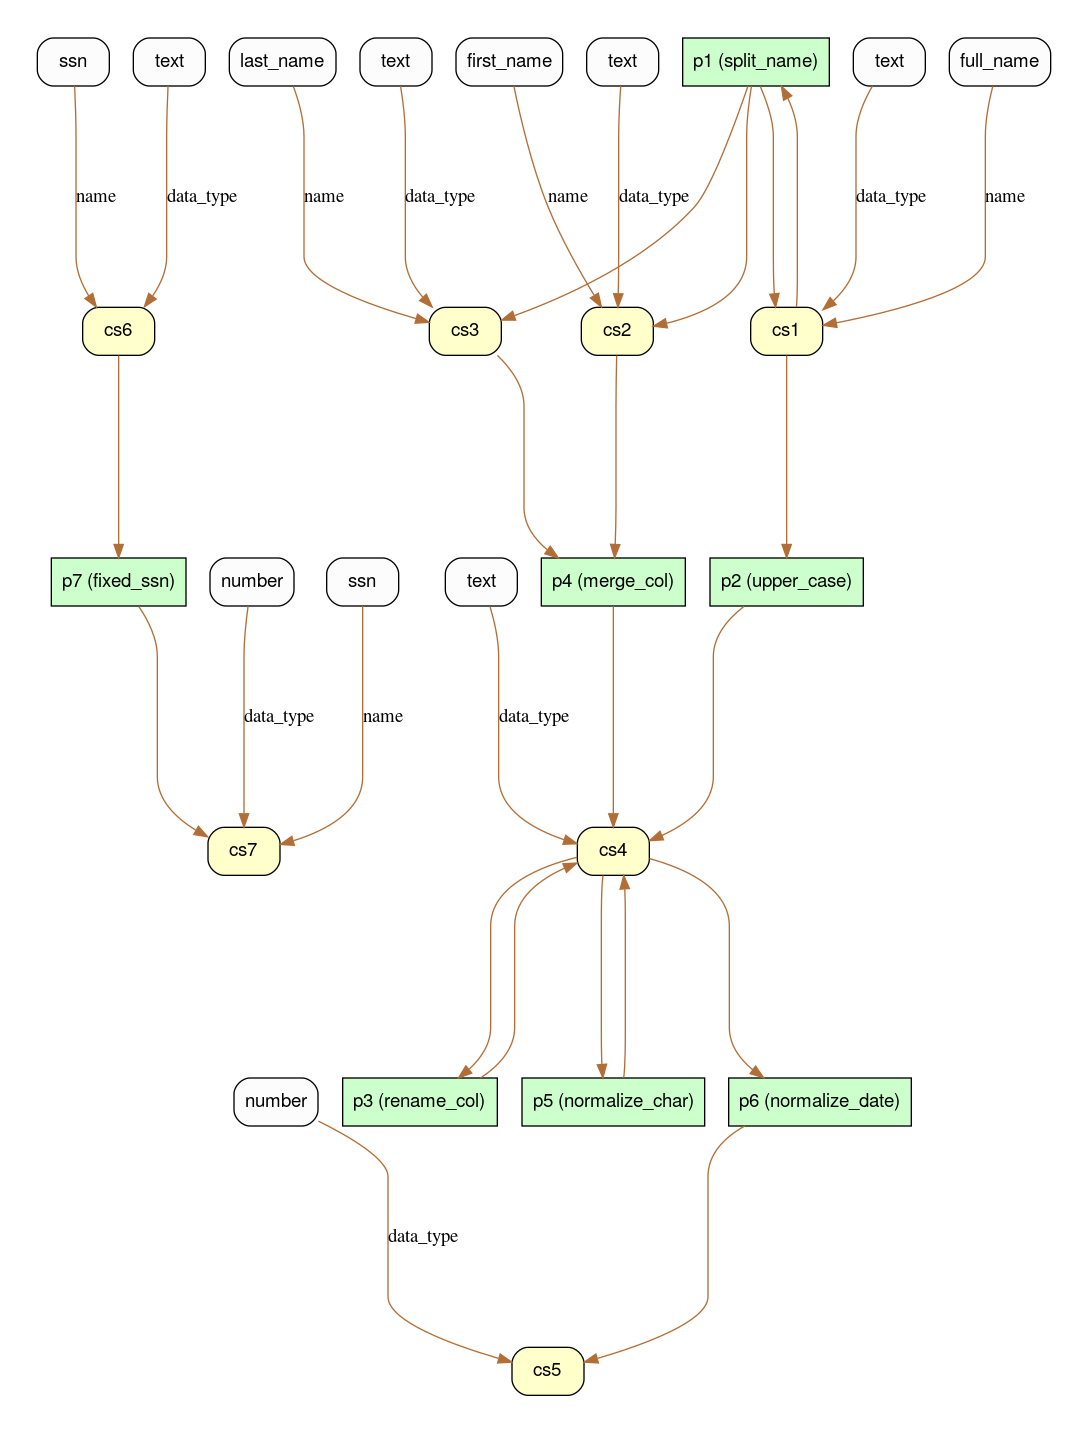

In [48]:
generate_pdf(gv_string,"process_model")

In [145]:
df_output_str[("column_schema",3)]

[['column_schema', 'cs11', 'name', 'full_name'],
 ['column_schema', 'cs11', 'data_type', 'text'],
 ['column_schema', 'cs12', 'name', 'first_name'],
 ['column_schema', 'cs12', 'data_type', 'text'],
 ['column_schema', 'cs13', 'name', 'last_name'],
 ['column_schema', 'cs13', 'data_type', 'text'],
 ['column_schema', 'cs13_1', 'name', 'ssn'],
 ['column_schema', 'cs13_1', 'data_type', 'number'],
 ['column_schema', 'cs14', 'data_type', 'text'],
 ['column_schema', 'cs15', 'data_type', 'number']]

In [101]:
x.context.symbolic_atoms.signatures

[('column_schema', 3, True),
 ('parameter', 3, True),
 ('process', 2, True),
 ('process_blueprint', 4, True),
 ('workflow_step', 3, True),
 ('step_input_schema', 3, True),
 ('workflow_input_violation', 3, True),
 ('step_output_schema', 3, True),
 ('workflow_output_violation', 3, True),
 ('dq_problem', 2, True),
 ('step_dq_problem', 3, True),
 ('dq_problem_violation', 3, True),
 ('workflow_input', 5, True),
 ('output_process', 2, True),
 ('inject_workflow_step', 1, True),
 ('inject_violation', 6, True),
 ('input_process', 2, True),
 ('recipe', 4, True),
 ('recipe_input_sink', 2, True),
 ('recipe_output_sink', 2, True),
 ('reuse_recipe', 1, True),
 ('reuse_violation', 4, True),
 ('inject_violation_checking', 6, True),
 ('select_workflow_step', 4, True),
 ('injected_parameter', 4, True),
 ('process_schema', 5, True),
 ('workflow_path', 4, True),
 ('example_flow', 4, True),
 ('column', 4, True),
 ('dataset', 2, True),
 ('array', 2, True),
 ('parameter', 4, True),
 ('update_workflow_step', 

In [106]:
for y in x.context.symbolic_atoms.by_signature("column_schema",3):
    print(y.symbol)

column_schema(cs11,name,full_name)
column_schema(cs11,data_type,text)
column_schema(cs12,name,first_name)
column_schema(cs12,data_type,text)
column_schema(cs13,name,last_name)
column_schema(cs13,data_type,text)
column_schema(cs13_1,name,ssn)
column_schema(cs13_1,data_type,number)
column_schema(cs14,data_type,text)
column_schema(cs15,data_type,number)


In [107]:
for y in x.context.symbolic_atoms.by_signature("workflow_step",3):
    print(y.symbol)

workflow_step(column_state(c11,1),p1,column_state(c11,2))
workflow_step(column_state(c11,1),p1,column_state(c12,1))
workflow_step(column_state(c11,1),p1,column_state(c13,1))
workflow_step(column_state(c12,1),p1,column_state(c12,2))
workflow_step(column_state(c12,1),p6,column_state(c12,2))
workflow_step(column_state(c12,1),p6,column_state(c13_1,1))


In [108]:
for y in x.context.symbolic_atoms.by_signature("step_input_schema",3):
    print(y.symbol)

step_input_schema(column_state(c11,1),p1,column_schema(cs11,name,full_name))
step_input_schema(column_state(c11,1),p1,column_schema(cs11,data_type,text))
step_input_schema(column_state(c12,1),p1,column_schema(cs12,name,first_name))
step_input_schema(column_state(c12,1),p1,column_schema(cs12,data_type,text))
step_input_schema(column_state(c12,1),p6,column_schema(cs12,name,first_name))
step_input_schema(column_state(c12,1),p6,column_schema(cs12,data_type,text))


In [129]:
y.symbol.name

'step_input_schema'

In [122]:
str(y.symbol.arguments[0])

'column_state(c12,1)'

In [123]:
str(y.symbol.arguments[1])

'p6'

In [124]:
str(y.symbol.arguments[2])

'column_schema(cs12,data_type,text)'

In [70]:
test = ctl.solve(on_model=on_model)

workflow_input_violation(column_state(c12,1),p1,column_schema(cs11,name,full_name)) workflow_output_violation(column_state(c12,1),p1,column_schema(cs11,name,full_name)) workflow_output_violation(column_state(c12,1),p1,column_schema(cs13,name,last_name)) dq_problem_violation(column_state(c11,1),p1,null_value) dq_problem_violation(column_state(c12,1),p6,date_format_error)


In [72]:
test.unknown

False

In [44]:
result = prolog_sentences.parseString(facts)

ParseException: Expected ")", found '1'  (at char 9), (line:1, col:10)

In [40]:
result

(['track', '1', '2.0', '4000', '3', '300', 'track', '2', '1.0', '9000', '5', '500', 'track', '3', '7.0', '9000', '2', '200'], {'relationship': ['track', 'track', 'track'], 'arguments': [(['1', '2.0', '4000', '3', '300'], {}), (['2', '1.0', '9000', '5', '500'], {}), (['3', '7.0', '9000', '2', '200'], {})], 'facts': [(['track', '1', '2.0', '4000', '3', '300'], {}), (['track', '2', '1.0', '9000', '5', '500'], {}), (['track', '3', '7.0', '9000', '2', '200'], {})]})

In [35]:
test="""track(1, 2.0, 4000, 3, 300).
track(2, 1.0, 9000, 5, 500).
track(3, 7.0, 9000, 2, 200)."""

result = prolog_sentences.parseString(test)

print(result['facts'][0])
# outputs ['1', '2.0', '4000', '3', '300']

print(result['facts'][1]['relationship'])
# outputs 'track'

print(result['facts'][2]['arguments'][1])


['track', '1', '2.0', '4000', '3', '300']


KeyError: 'relationship'